In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import scikitplot as skplt
import os
from scipy.stats import gaussian_kde
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import confusion_matrix

In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
%matplotlib inline
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
warnings.filterwarnings('ignore')

# Class Plot

In [3]:
class CreatePlot:    
    
    def __init__(self, folder_name):
        self.folder_name = folder_name
        
    def interval_splitter(self, data, col_tuple):
        data['lower_bin'] = data[col_tuple].apply(lambda x: x.left)
        data['upper_bin'] = data[col_tuple].apply(lambda x: x.right)
        data[['lower_bin', 'upper_bin']] = data[['lower_bin', 'upper_bin']].astype('float64')
        data['width_bin'] = data['upper_bin'] - data['lower_bin']
        return data    
    
    def save_options(self, folder_name, file_name = None):
        
        while True:
            save = input("Would you like to save it? y/n \n")
            
            if save.lower() == 'n':
                plt.show()
                break
            elif save.lower() == 'y':
                if not os.path.exists(self.folder_name):
                    os.makedirs(self.folder_name)
                plt.savefig(self.folder_name + '/' + file_name + '.png')
                #plt.savefig(self.folder_name + '/' + feature + ' (Predictor)' + ' vs ' + target + ' (Target)' + '.png')
                plt.show()
                break
            else:# save.lower not in ('y', 'n'):
                print('Please use only y/n : \n')
        
            plt.close(fig)
        
    def generate_all(self, df, target, bins = 15):
        
        features_list = [col for col in df.columns.tolist() if col != target]
        
        if not os.path.exists(self.folder_name):
            os.makedirs(self.folder_name)
        
        for feat in features_list:
            single_df = df[[feat, target]]
            single_df.columns = ['predictor', 'target']
            
            if 'int' in single_df.dtypes[0].name or 'float' in single_df.dtypes[0].name:
                print(feat)
                single_df['predictor_bins'] = pd.cut(single_df['predictor'], bins) # may need to be more dynamica choosing buckets
                groupped = (single_df.groupby('predictor_bins')
                                .agg({'predictor': 'count',
                                      'target': lambda x: sum(x == 1) / len(x)})
                                .reset_index()
                                .sort_values('predictor_bins'))
                groupped = self.interval_splitter(groupped, 'predictor_bins')
                
                plt.figure()
                plt.style.use('dark_background')
                fig, ax1 = plt.subplots(figsize = (20, 10))
                ax2 = ax1.twinx()
                
                ax1.grid(False)
                ax2.grid(False)
                
                sns.barplot( x = groupped.index,
                             y = groupped.predictor,
                             color = 'royalblue',
                             ax = ax1)
                
                sns.lineplot(x = groupped.index,
                             y = groupped.target,
                             color = 'yellow',
                             ax = ax2,
                             linewidth = 5,
                             marker = 'o',
                             markerfacecolor = 'yellow',
                             markersize = 12)
                
                plt.xticks(np.arange(0, 15, 1), labels = groupped.upper_bin)
                plt.tight_layout()
                plt.savefig(self.folder_name + '/' + feat + ' (Predictor)' + ' vs ' + target + ' (Target)' + '.png')
                plt.close(fig)
            

    def generate_one(self, df, feature, target, bins = 15, fig_size = (20,10), keep_outliers = 'yes'):
        
        file_name = feature + ' (Predictor)' + ' vs ' + target + ' (Target)'
        single_df = df[[feature, target]]
        
        if keep_outliers == 'no':
            single_df[feature] = single_df[feature].apply(lambda x : np.nan if x > (single_df[feature].mean() + 3 * single_df[feature].std()) else x)
            single_df = single_df.dropna()
        else:
            pass
            
        single_df.columns = ['predictor', 'target']
        
        single_df['predictor_bins'] = pd.cut(single_df['predictor'], bins) # may need to be more dynamica choosing buckets
        groupped = (single_df.groupby('predictor_bins')
                                .agg({'predictor': 'count',
                                      'target': lambda x: sum(x == 1) / len(x)})
                                .reset_index()
                                .sort_values('predictor_bins'))
        groupped = self.interval_splitter(groupped, 'predictor_bins')
        plt.figure()
        plt.style.use('dark_background')
        fig, ax1 = plt.subplots(figsize = fig_size)
        ax2 = ax1.twinx()

        ax1.grid(False)
        ax2.grid(False)

        sns.barplot( x = groupped.index,
                     y = groupped.predictor,
                     color = 'royalblue',
                     ax = ax1)

        sns.lineplot(x = groupped.index,
                     y = groupped.target,
                     color = 'yellow',
                     ax = ax2,
                     linewidth = 5,
                     marker = 'o',
                     markerfacecolor = 'yellow',
                     markersize = 12)
        plt.xticks(np.arange(0, bins, 1), labels = groupped.upper_bin)
        plt.title(feature + ' vs ' + target, fontsize=30)
        
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)        
        
    def correlation_plot(self, df, fig_size = (20, 20)):
        
        file_name = 'correlation matrix'
        corr_matrix = df.corr()
        mask = np.zeros_like(corr_matrix, dtype = np.bool)
        mask[np.triu_indices_from(mask)] = True
        cmap = 'YlGnBu'
    
        plt.figure(figsize = fig_size)
        ax = sns.heatmap(corr_matrix, mask = mask, annot = True, annot_kws = {"size": 12}, cmap = cmap)
        #this is for the matplotlib bug for the heatmap
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def pearson_corr_target(self, df, target, n_to_see = 20, fig_size = (20, 20)):
    #Correlation with the target
        
        file_name = 'Correlation vs ' + target
        top_correlation = df.corr().loc[[target]].T.reset_index().rename(columns = {'index':'feature'})
        top_correlation['abs'] = np.abs(top_correlation[target])
        top_correlation = top_correlation.sort_values('abs', ascending = False).iloc[1:n_to_see + 1]
        plt.figure(figsize = fig_size)
        plt.barh(top_correlation['feature'], top_correlation[target], color = 'royalblue')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=30)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def confusion_matrix_plot(self, y_true, model, X_test, fig_size = (8, 5), color = 'Blues'):
        
        file_name = 'Confusion Matrix for the model ' + str(model).split('(')[0]
        plt.figure(figsize = fig_size)
        ax = (sns.heatmap(
            pd.DataFrame(confusion_matrix(y_true, model.predict(X_test))), 
            annot = True,
            annot_kws = {"size": 12}, 
            cmap = color))
        plt.title('Confusion Matrix', fontdict = {'fontsize' : 30}, pad=30)
        plt.xlabel('Predicted', fontdict = {'fontsize' : 20})
        plt.ylabel('Actual', fontdict = {'fontsize' : 20})
         #this is for the matplotlib bug for the heatmap
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def probability_density_plot(self, y_true, model, X_test, target, n_class = 2):
        
        df_results = y_true.reset_index()
        prediction = model.predict(X_test)
        df_results['prediction'] = prediction
        prob = [model.predict_proba(X_test)]
        ser_prob = [prob[0][i][1] for i in range(len(prob[0]))]
        df_results['probability'] = ser_prob
        
        
        background = '#132C47'
        file_name = 'Prediction Distribution of an event'
        fig = plt.figure(figsize=(12, 10))
        axes = fig.add_subplot(1, 1, 1, facecolor = background)
        xs = np.linspace(0, 1, 100)
        
        if n_class == 2:
            density_neg = gaussian_kde(df_results[df_results[target] == 0]['probability'], bw_method=0.2)
            plt.plot(xs, density_neg(xs), color = 'white')
            plt.fill_between(xs, 0, density_neg(xs), color = 'white', alpha=0.3)

            density_pos = gaussian_kde(df_results[df_results[target] == 1]['probability'], bw_method=0.2)
            plt.plot(xs, density_pos(xs), color = 'yellow')
            plt.fill_between(xs, 0, density_pos(xs), color = 'yellow', alpha=0.3)
        
        elif n_class == 3:
            density_0 = gaussian_kde(df_results[df_results[target] == 0]['probability'], bw_method=0.2)
            plt.plot(xs, density_0(xs), color = 'white')
            plt.fill_between(xs, 0, density_0(xs), color = 'white', alpha=0.3)

            density_1 = gaussian_kde(df_results[df_results[target] == 1]['probability'], bw_method=0.2)
            plt.plot(xs, density_1(xs), color = 'yellow')
            plt.fill_between(xs, 0, density_1(xs), color = 'yellow', alpha=0.3)
            
            density_2 = gaussian_kde(df_results[df_results[target] == 2]['probability'], bw_method=0.2)
            plt.plot(xs, density_2(xs), color = 'red')
            plt.fill_between(xs, 0, density_2(xs), color = 'red', alpha=0.3)
            
        elif n_class == 4:
            density_0 = gaussian_kde(df_results[df_results[target] == 0]['probability'], bw_method=0.2)
            plt.plot(xs, density_0(xs), color = 'white')
            plt.fill_between(xs, 0, density_0(xs), color = 'white', alpha=0.3)

            density_1 = gaussian_kde(df_results[df_results[target] == 1]['probability'], bw_method=0.2)
            plt.plot(xs, density_1(xs), color = 'yellow')
            plt.fill_between(xs, 0, density_1(xs), color = 'yellow', alpha=0.3)
            
            density_2 = gaussian_kde(df_results[df_results[target] == 2]['probability'], bw_method=0.2)
            plt.plot(xs, density_2(xs), color = 'red')
            plt.fill_between(xs, 0, density_2(xs), color = 'red', alpha=0.3)
            
            density_3 = gaussian_kde(df_results[df_results[target] == 3]['probability'], bw_method=0.2)
            plt.plot(xs, density_3(xs), color = 'green')
            plt.fill_between(xs, 0, density_3(xs), color = 'green', alpha=0.3)

        else:
            print('Not supported yet')
            
        plt.title('Prediction Distribution', fontdict = {'fontsize' : 30}, pad=30)
        plt.xlabel('Probability of Event', fontdict = {'fontsize' : 20})
        plt.ylabel('Probability Density', fontdict = {'fontsize' : 20})
        plt.xticks(np.arange(0, 1, 0.05))
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def roc_plot(self, y_true, X_test, model, color = 'PuBu', fig_size = (15, 8)):
        
        file_name = 'Roc for the model ' + str(model).split('(')[0]
        skplt.metrics.plot_roc(y_true, model.predict_proba(X_test), plot_micro = False, plot_macro = False, cmap = color, figsize = fig_size)
        plt.title('ROC Curves', fontdict = {'fontsize' : 30})
        plt.xlabel('False Positive Rate', fontdict = {'fontsize' : 20})
        plt.ylabel('True Positive Rate', fontdict = {'fontsize' : 20})
        plt.legend(loc=4, prop={'size': 20})
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)

    def precision_recall_plot(self, y_true, X_test, model, color = 'PuBu', fig_size = (15, 8)):
        
        file_name = 'Precision Recall for the model ' + str(model).split('(')[0]
        skplt.metrics.plot_precision_recall(y_true, model.predict_proba(X_test), plot_micro = False, cmap = color, figsize = fig_size)
        plt.title('Precision Recall', fontdict = {'fontsize' : 30})
        plt.xlabel('Recall', fontdict = {'fontsize' : 20})
        plt.ylabel('Precision', fontdict = {'fontsize' : 20})
        plt.legend(loc=4, prop={'size': 20})
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def target_vs_prediction_feature_plot(self, y_true, model, X_test , feature, bins, target):
        
        
        df_results = y_true.reset_index()
        prediction = model.predict(X_test)
        df_results['prediction'] = prediction
        prob = [model.predict_proba(X_test)]
        ser_prob = [prob[0][i][1] for i in range(len(prob[0]))]
        df_results['probability'] = ser_prob
        X_test_2 = X_test.reset_index()
        df_results = pd.merge(df_results, X_test_2, how = 'left', on = 'index')
        
        file_name = feature + ' vs ' + target + ' vs prediction'
        single_df = df_results[[feature, target, 'prediction']]
        single_df.columns = ['predictor', 'target', 'prediction']
        
        single_df['predictor_bins'] = pd.cut(single_df['predictor'], bins) # may need to be more dynamica choosing buckets
        groupped = (single_df.groupby('predictor_bins')
                                .agg({'predictor': 'count',
                                      'target': lambda x: sum(x == 1) / len(x),
                                      'prediction' : lambda x: sum(x == 1) / len(x)})
                                .reset_index()
                                .sort_values('predictor_bins'))
        groupped = self.interval_splitter(groupped, 'predictor_bins')
        plt.figure()
        plt.style.use('dark_background')
        fig, ax1 = plt.subplots(figsize = (20, 15))
        ax2 = ax1.twinx()

        ax1.grid(False)
        ax2.grid(False)

        sns.barplot( x = groupped.index,
                     y = groupped.predictor,
                     color = 'blue',
                     ax = ax1)

        sns.lineplot(x = groupped.index,
                     y = groupped.target,
                     color = 'yellow',
                     ax = ax2,
                     linewidth = 5,
                     marker = 'o',
                     markerfacecolor = 'yellow',
                     markersize=12)
        
        sns.lineplot(x = groupped.index,
                     y = groupped.prediction,
                     color = 'red',
                     ax = ax2,
                     linewidth = 5,
                     marker = 'P',
                     markerfacecolor = 'red',
                     markersize=20)        
        plt.xticks(np.arange(0, bins, 1), labels = groupped.upper_bin)
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def calibration_curve_plot(self, y_true, probability_list, name_list):
        
        file_name = 'Calibration Curve'
        skplt.metrics.plot_calibration_curve(y_true, probability_list, name_list, cmap='gist_rainbow', figsize=(15,8))
        plt.legend(loc = 4, prop={'size': 20})
        plt.title('Calibration Plots (Reliability Curves)', fontdict = {'fontsize' : 30})
        plt.xlabel('Mean Predicted Value', fontdict = {'fontsize' : 20})
        plt.ylabel('Fraction of Positive', fontdict = {'fontsize' : 20})
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)

    def feature_distribution(self, df, feat_to_check, n_bins = None, keep_outliers = 'yes'):
        
        file_name = feat_to_check + ' distribution'
        single_dist = df[[feat_to_check]]
        
        if keep_outliers == 'no':
            single_dist[feat_to_check] = single_dist[feat_to_check].apply(lambda x : np.nan if x > (single_dist[feat_to_check].mean() + 3 * single_dist[feat_to_check].std()) else x)
            single_dist = single_dist.dropna()
        else:
            pass
        
        plt.figure(figsize=(12, 8))
        sns.distplot(single_dist[feat_to_check], 
                     bins = n_bins,
                     kde_kws={"color": "yellow", "lw": 3},
                     hist_kws={"alpha": 0.8, "color": "royalblue", 'lw':1})
        plt.tight_layout()
        #self.save_options(self.folder_name, file_name)
        plt.show()
    
    def feature_importance_plot(self, df, model, n_feat_to_see = 20, fig_size = (10, 15), x_font_size = 20, y_font_size = 30):
        
        file_name = 'Feature importance for the model ' + str(model).split('(')[0]
        model_features = pd.DataFrame({'feature': df.columns, 
                                       'importance': model.feature_importances_})
        model_features = (model_features[model_features['importance']>0]
                         .sort_values('importance', ascending=False)
                         .iloc[:n_feat_to_see])

        
        plt.figure(figsize = fig_size)
        plt.barh(model_features.feature, model_features.importance, color = 'royalblue')
        plt.xticks(fontsize = x_font_size)
        plt.yticks(fontsize = y_font_size)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        #self.save_options(self.folder_name, file_name)
        plt.show()
    def coefficients_plot(self, df, model, n_coef_to_see=20, fig_size = (20, 30), x_font_size = 20, y_font_size = 30):
        
        file_name = ('Coefficient')
        coefficients = (pd.DataFrame(list(zip(df.columns,
                                             model.coef_[0],
                                             np.abs(model.coef_[0])))
                                   , columns = ['Features', 'Coeff_value', 'Coeff_value_abs'])
                       .sort_values(by = 'Coeff_value_abs'))
        plt.figure(figsize = fig_size)
        plt.barh(coefficients.Features.head(30), coefficients.Coeff_value.head(30), color = 'royalblue')
        plt.xticks(fontsize = x_font_size)
        plt.yticks(fontsize = y_font_size)
        plt.tight_layout()
        plt.show()
        #self.save_options(self.folder_name, file_name)
        
    def tree_generation(self, df, tree_model,depth = 2):
        
        file_name = 'Decision Tree plot'
        print('Max depth:', tree_model.max_depth)
        dot_data = StringIO()
        export_graphviz(tree_model,
                        out_file=dot_data,
                        max_depth = depth,
                        filled=True,
                        rounded=True,
                        special_characters=True,
                        feature_names=df.columns
                        )

        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
        plt.tight_layout()
        return Image(graph.create_png())
        

# Use case

In [4]:
df = pd.read_csv('ionosphere.csv')
#df= pd.read_csv('iris.csv')

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,target
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,0.476183,0.155040,0.400801,0.093414,0.344159,0.071132,0.381949,-0.003617,0.359390,-0.024025,0.336695,0.008296,0.362475,-0.057406,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480,0.358974
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,0.563496,0.494817,0.622186,0.494873,0.652828,0.458371,0.618020,0.496762,0.626267,0.519076,0.609828,0.518166,0.603767,0.527456,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337,0.480384
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,0.021120,-0.065265,0.000000,-0.073725,0.000000,-0.081705,0.000000,-0.225690,0.000000,-0.234670,0.000000,-0.243870,0.000000,-0.366885,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350,0.000000
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,0.667980,0.028250,0.644070,0.030270,0.601940,0.000000,0.590910,0.000000,0.576190,0.000000,0.499090,0.000000,0.531760,0.000000,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000,0.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,0.957895,0.482375,0.955505,0.374860,0.919330,0.308975,0.935705,0.195285,0.899265,0.134370,0.894865,0.188760,0.911235,0.164630,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660,1.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#df = df.rename(columns = {'Name': 'target'})


In [7]:
#select = df.target.unique()
#voc = {select[i]:i for i in range(len(select))}
#df.target = df.target.map(voc)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,target
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,0
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,1
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,0
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,1
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,0


In [9]:
df.target.value_counts(normalize = True)

0    0.641026
1    0.358974
Name: target, dtype: float64

In [10]:
P = CreatePlot('plot')

<Figure size 576x504 with 0 Axes>

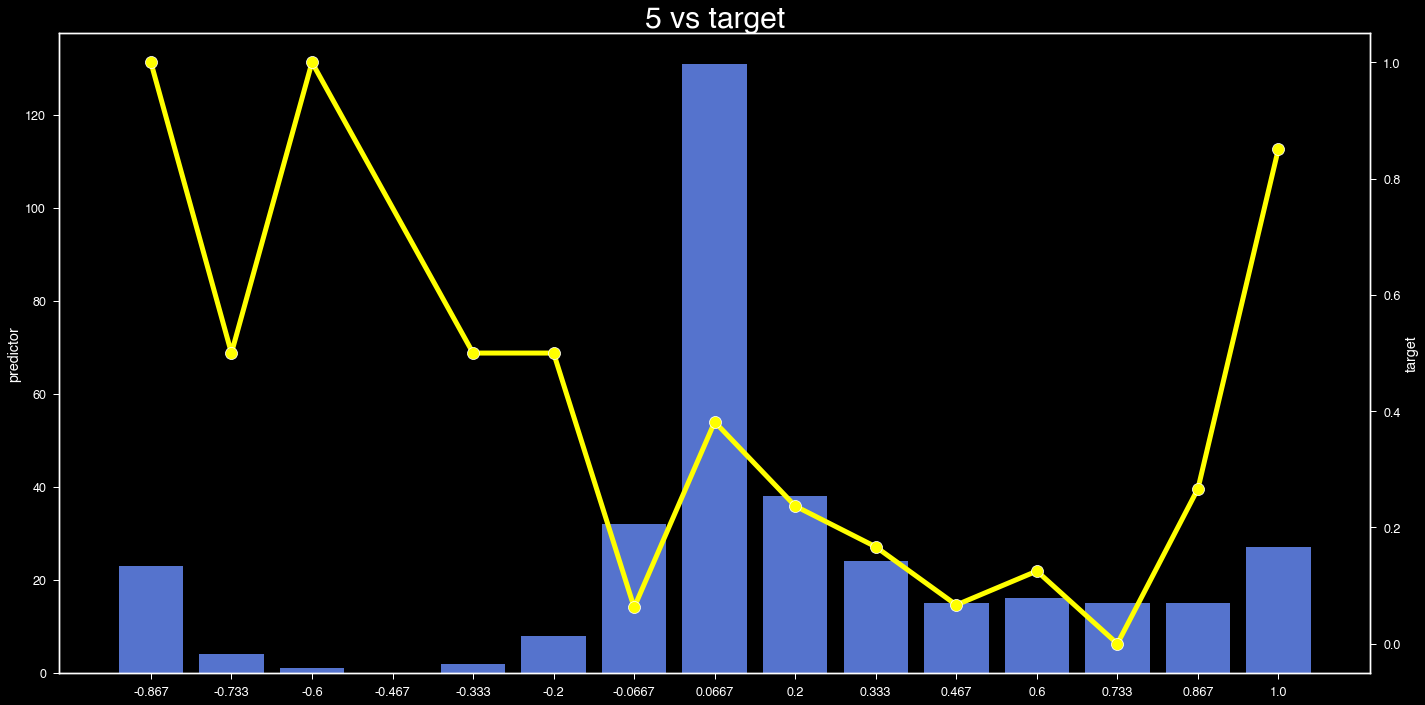

In [11]:
P.generate_one(df, '5', 'target')

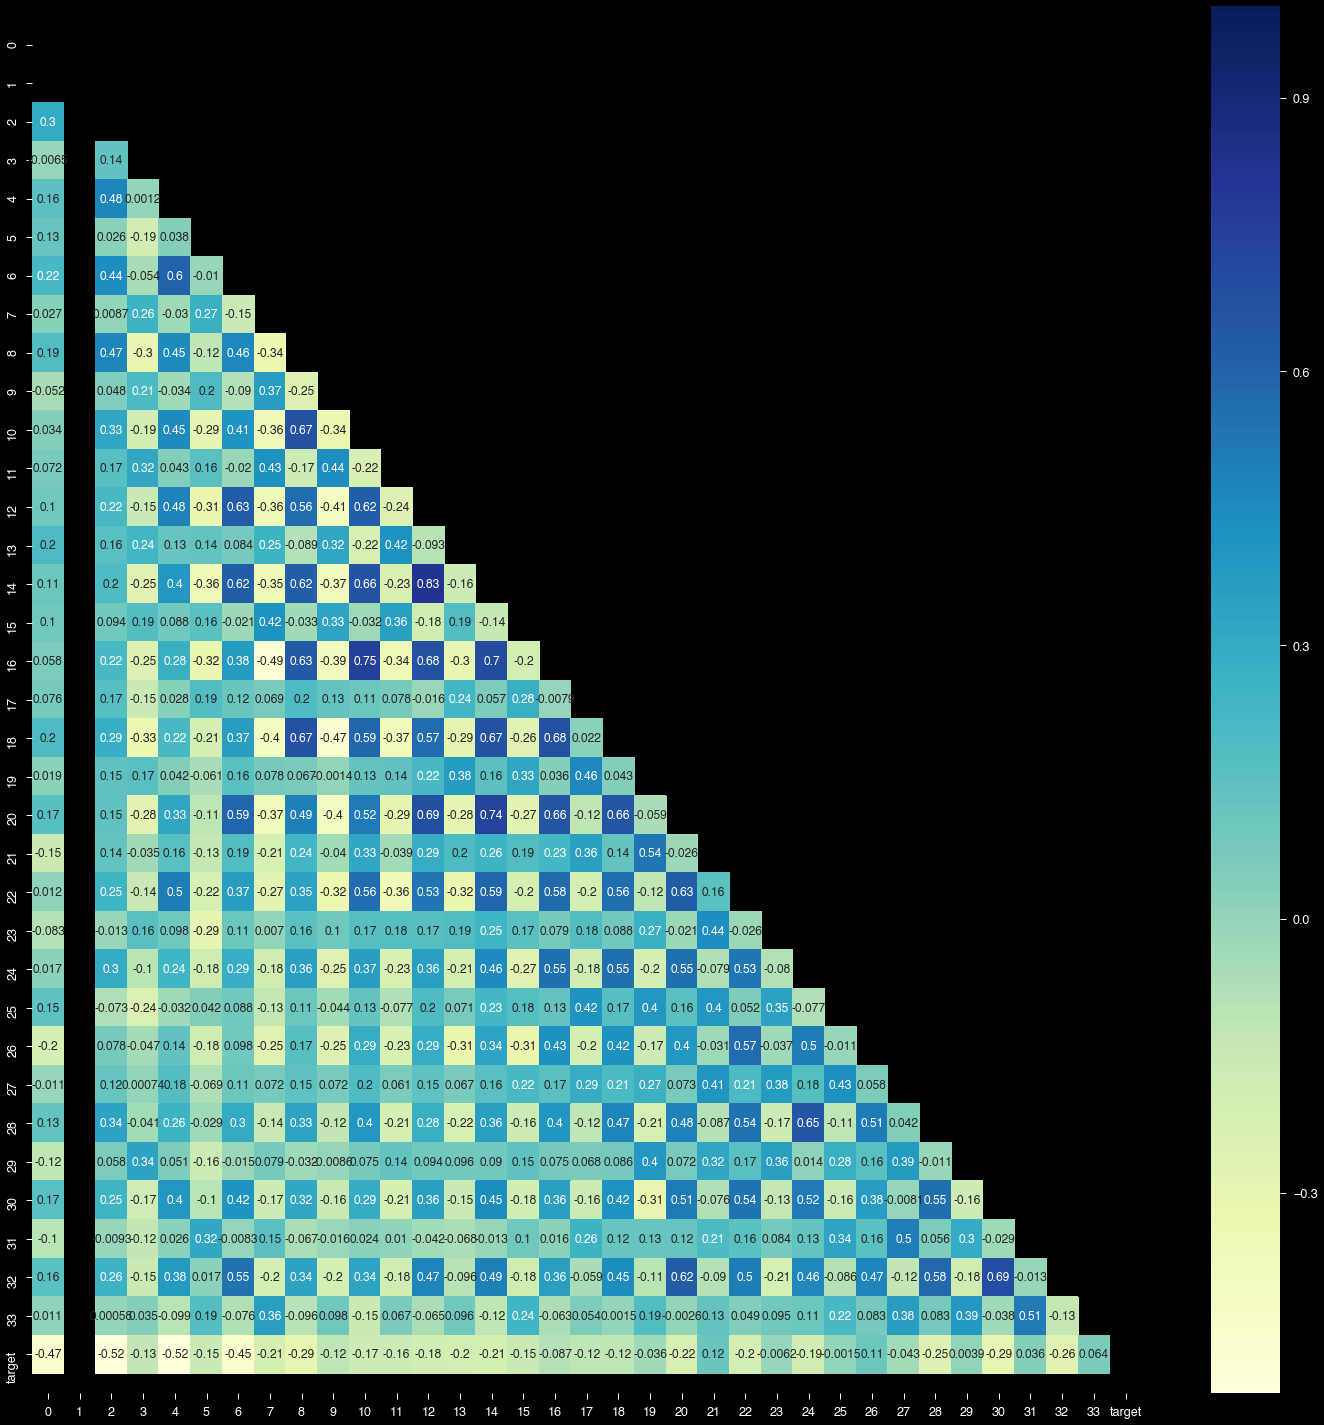

In [12]:
P.correlation_plot(df, fig_size=(20,20))

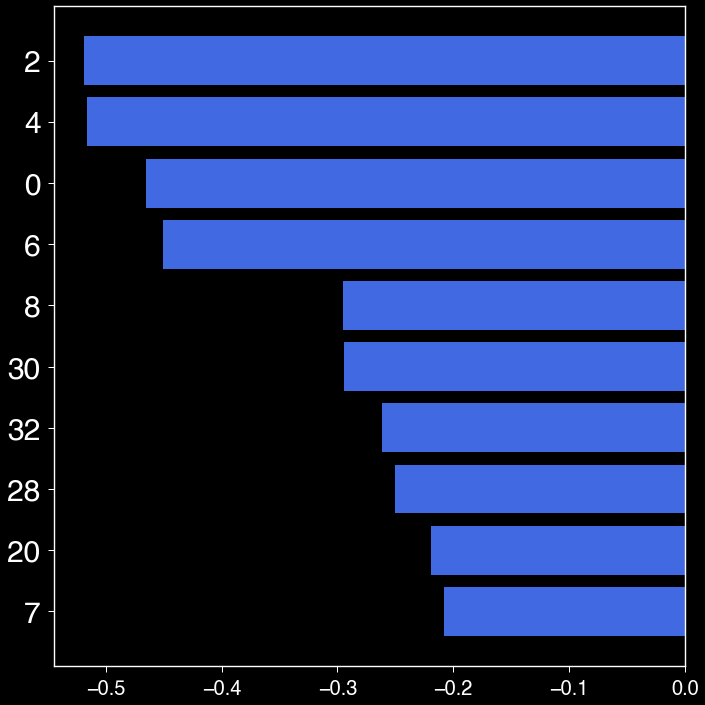

In [13]:
P.pearson_corr_target(df, 'target', fig_size=(10, 10), n_to_see = 10)

## Modelling

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [15]:
df = df.dropna()

In [16]:
Xc = df.copy(deep = True)
yc = df['target']
Xc.pop('target')
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size = 0.2, random_state=1)


In [17]:
cl = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
models = [cl, dt, rf]

In [18]:
for model in models:
    print(model)
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
    print()


LogisticRegression()
0.8732394366197183

DecisionTreeClassifier()
0.8028169014084507

RandomForestClassifier()
0.9154929577464789



# Evaluations plots

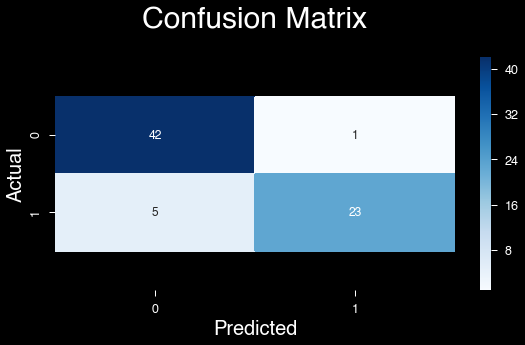

In [19]:
P.confusion_matrix_plot(y_test, rf, X_test)

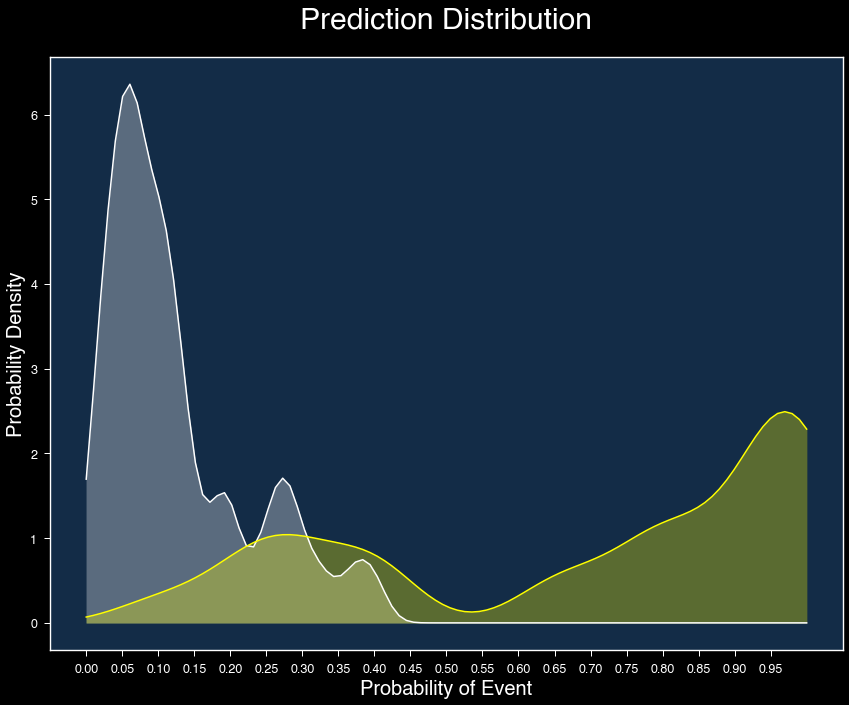

In [20]:
P.probability_density_plot(y_test, cl, X_test, 'target')

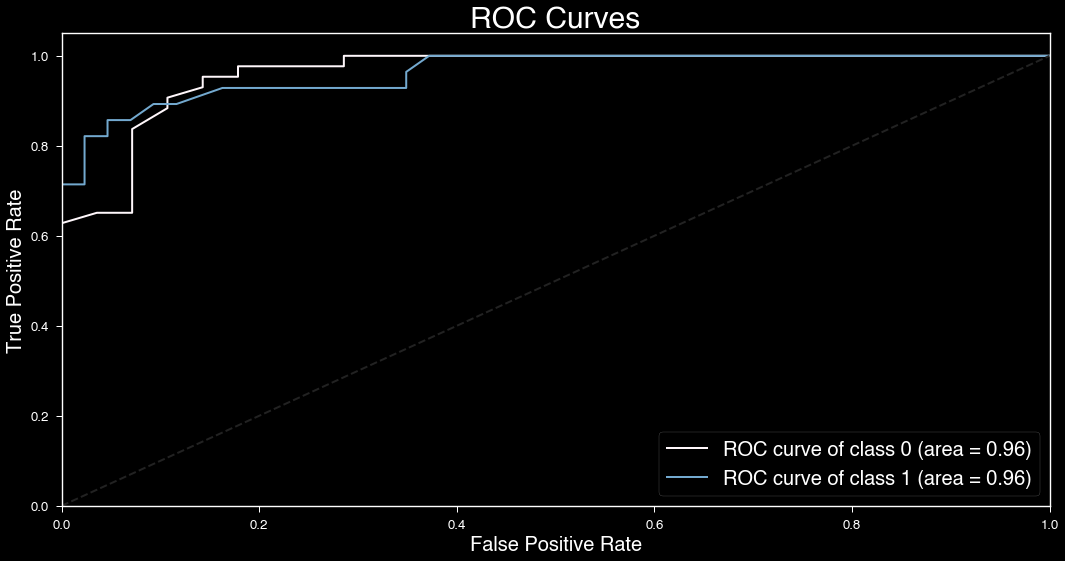

In [21]:
P.roc_plot(y_test, X_test, rf)

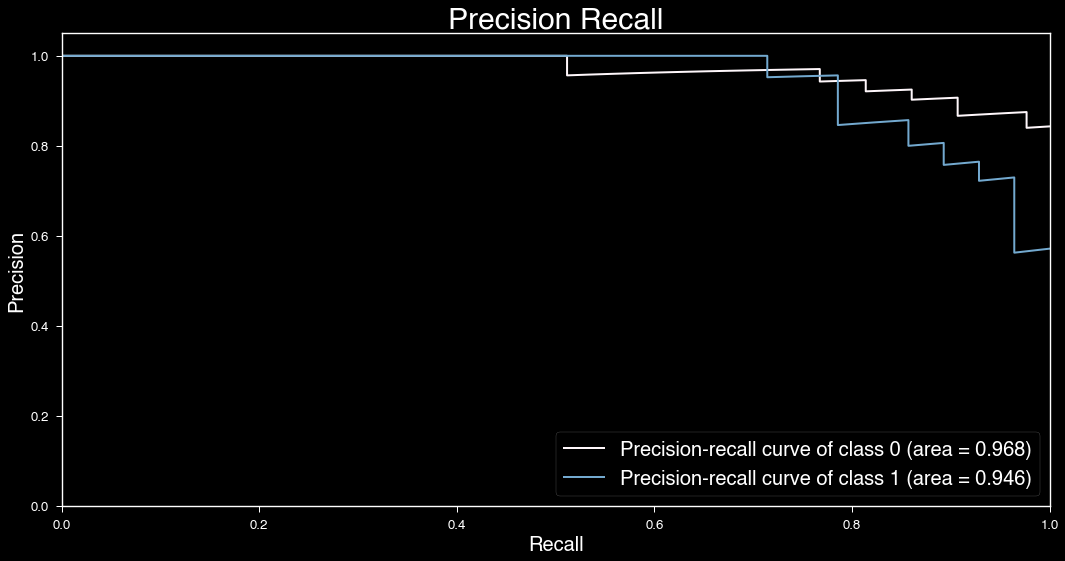

In [22]:
P.precision_recall_plot(y_test, X_test, cl)

In [23]:
# df_results = y_test.reset_index()
# prediction = rf.predict(X_test)
# df_results['prediction'] = prediction
# prob = [rf.predict_proba(X_test)]
# ser_prob = [prob[0][i][1] for i in range(len(prob[0]))]
# df_results['probability'] = ser_prob
# X_test_2 = X_test.reset_index()
# df_results = pd.merge(df_results, X_test_2, how = 'left', on = 'index')

In [24]:
# X_test_2 = X_test.reset_index()
# yy = pd.merge(yy, X_test_2, how = 'left', on = 'index')

<Figure size 576x504 with 0 Axes>

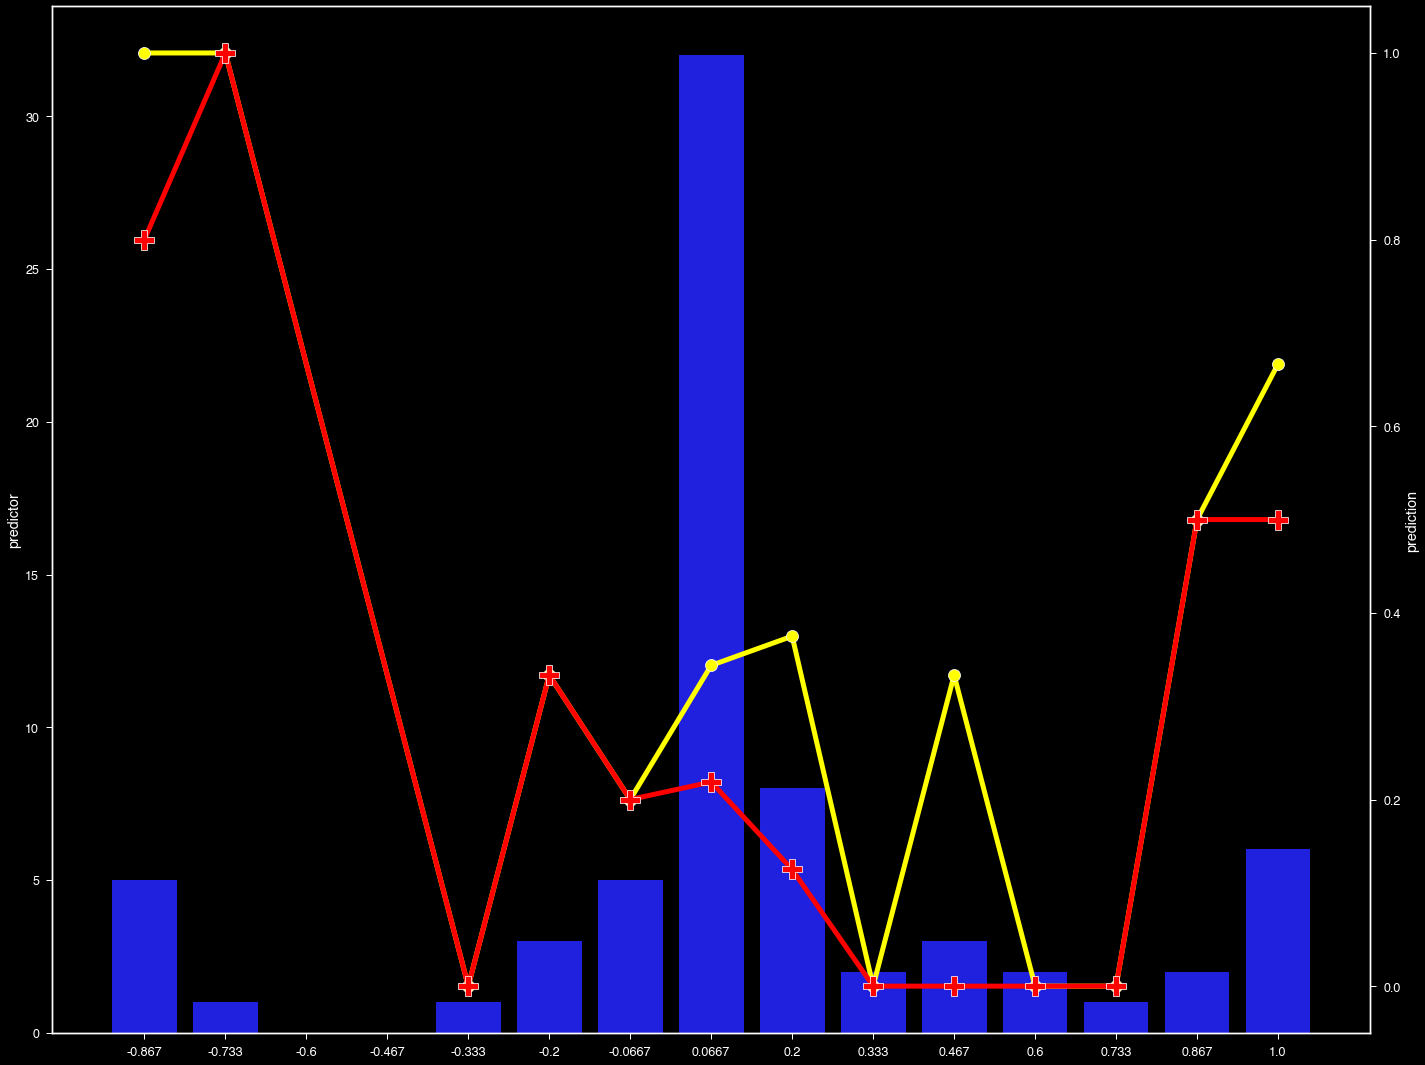

In [25]:
P.target_vs_prediction_feature_plot(y_test, cl, X_test, '5', 15, 'target')

In [26]:
prob_list = [cl.predict_proba(X_test), rf.predict_proba(X_test)]
mod_list = [cl, rf]

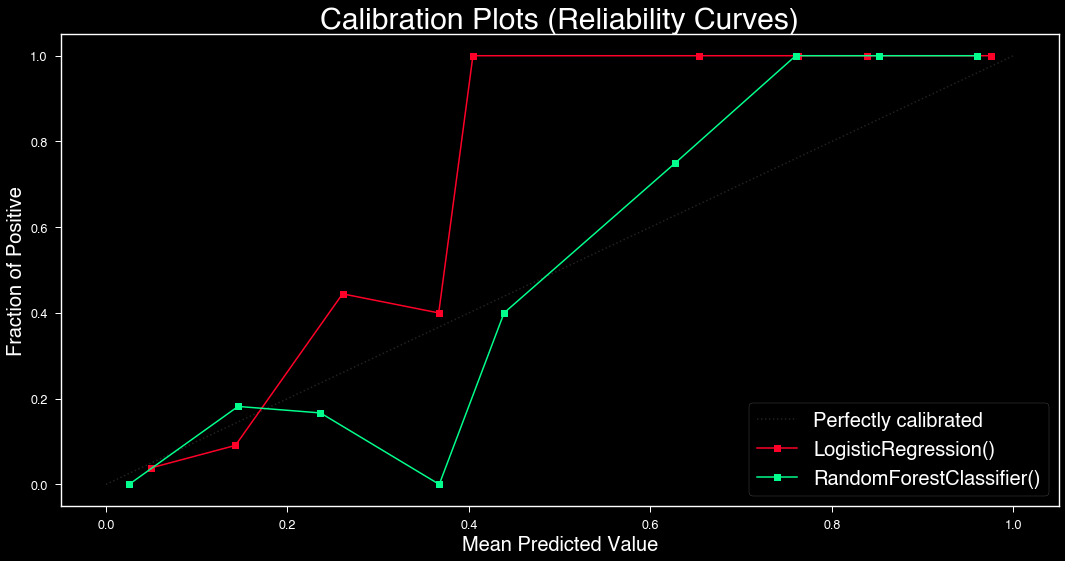

In [27]:
P.calibration_curve_plot(y_test, prob_list, mod_list)

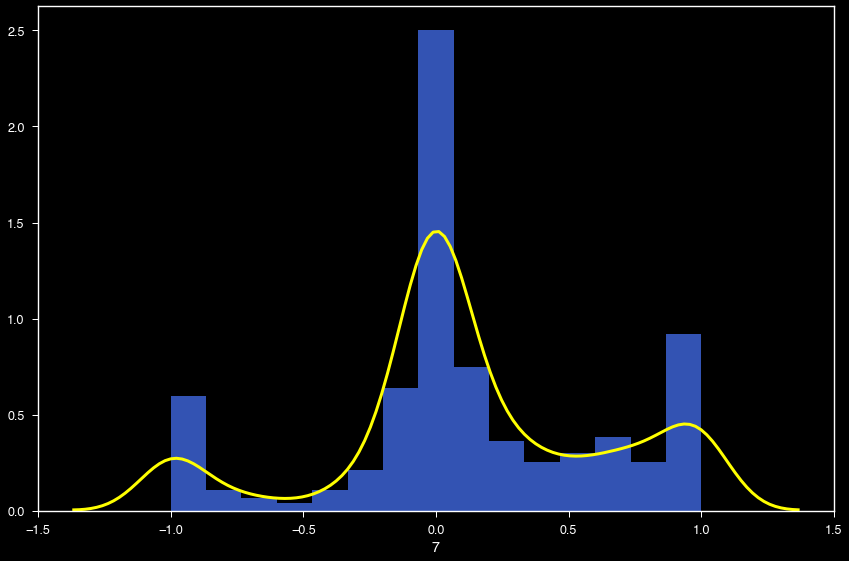

In [28]:
P.feature_distribution(df, '7')

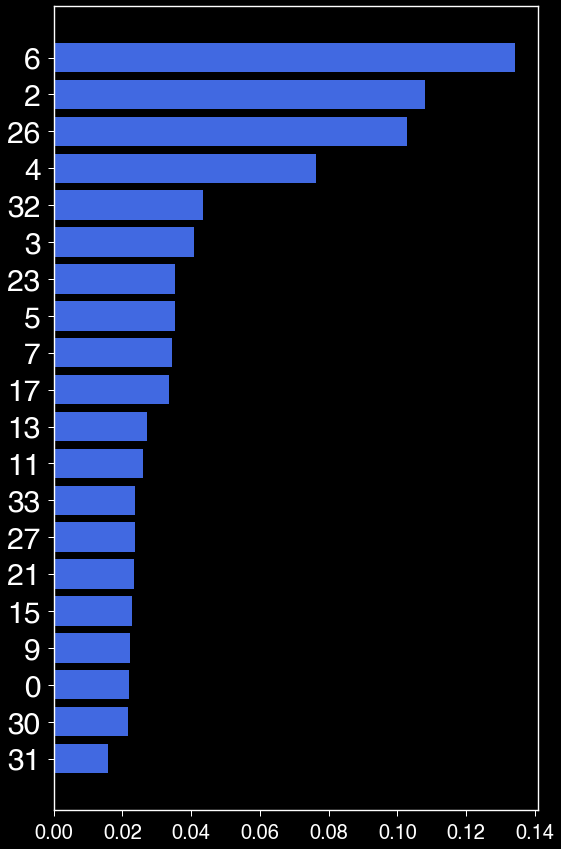

In [29]:
P.feature_importance_plot(X_test, rf, fig_size = (8, 12))

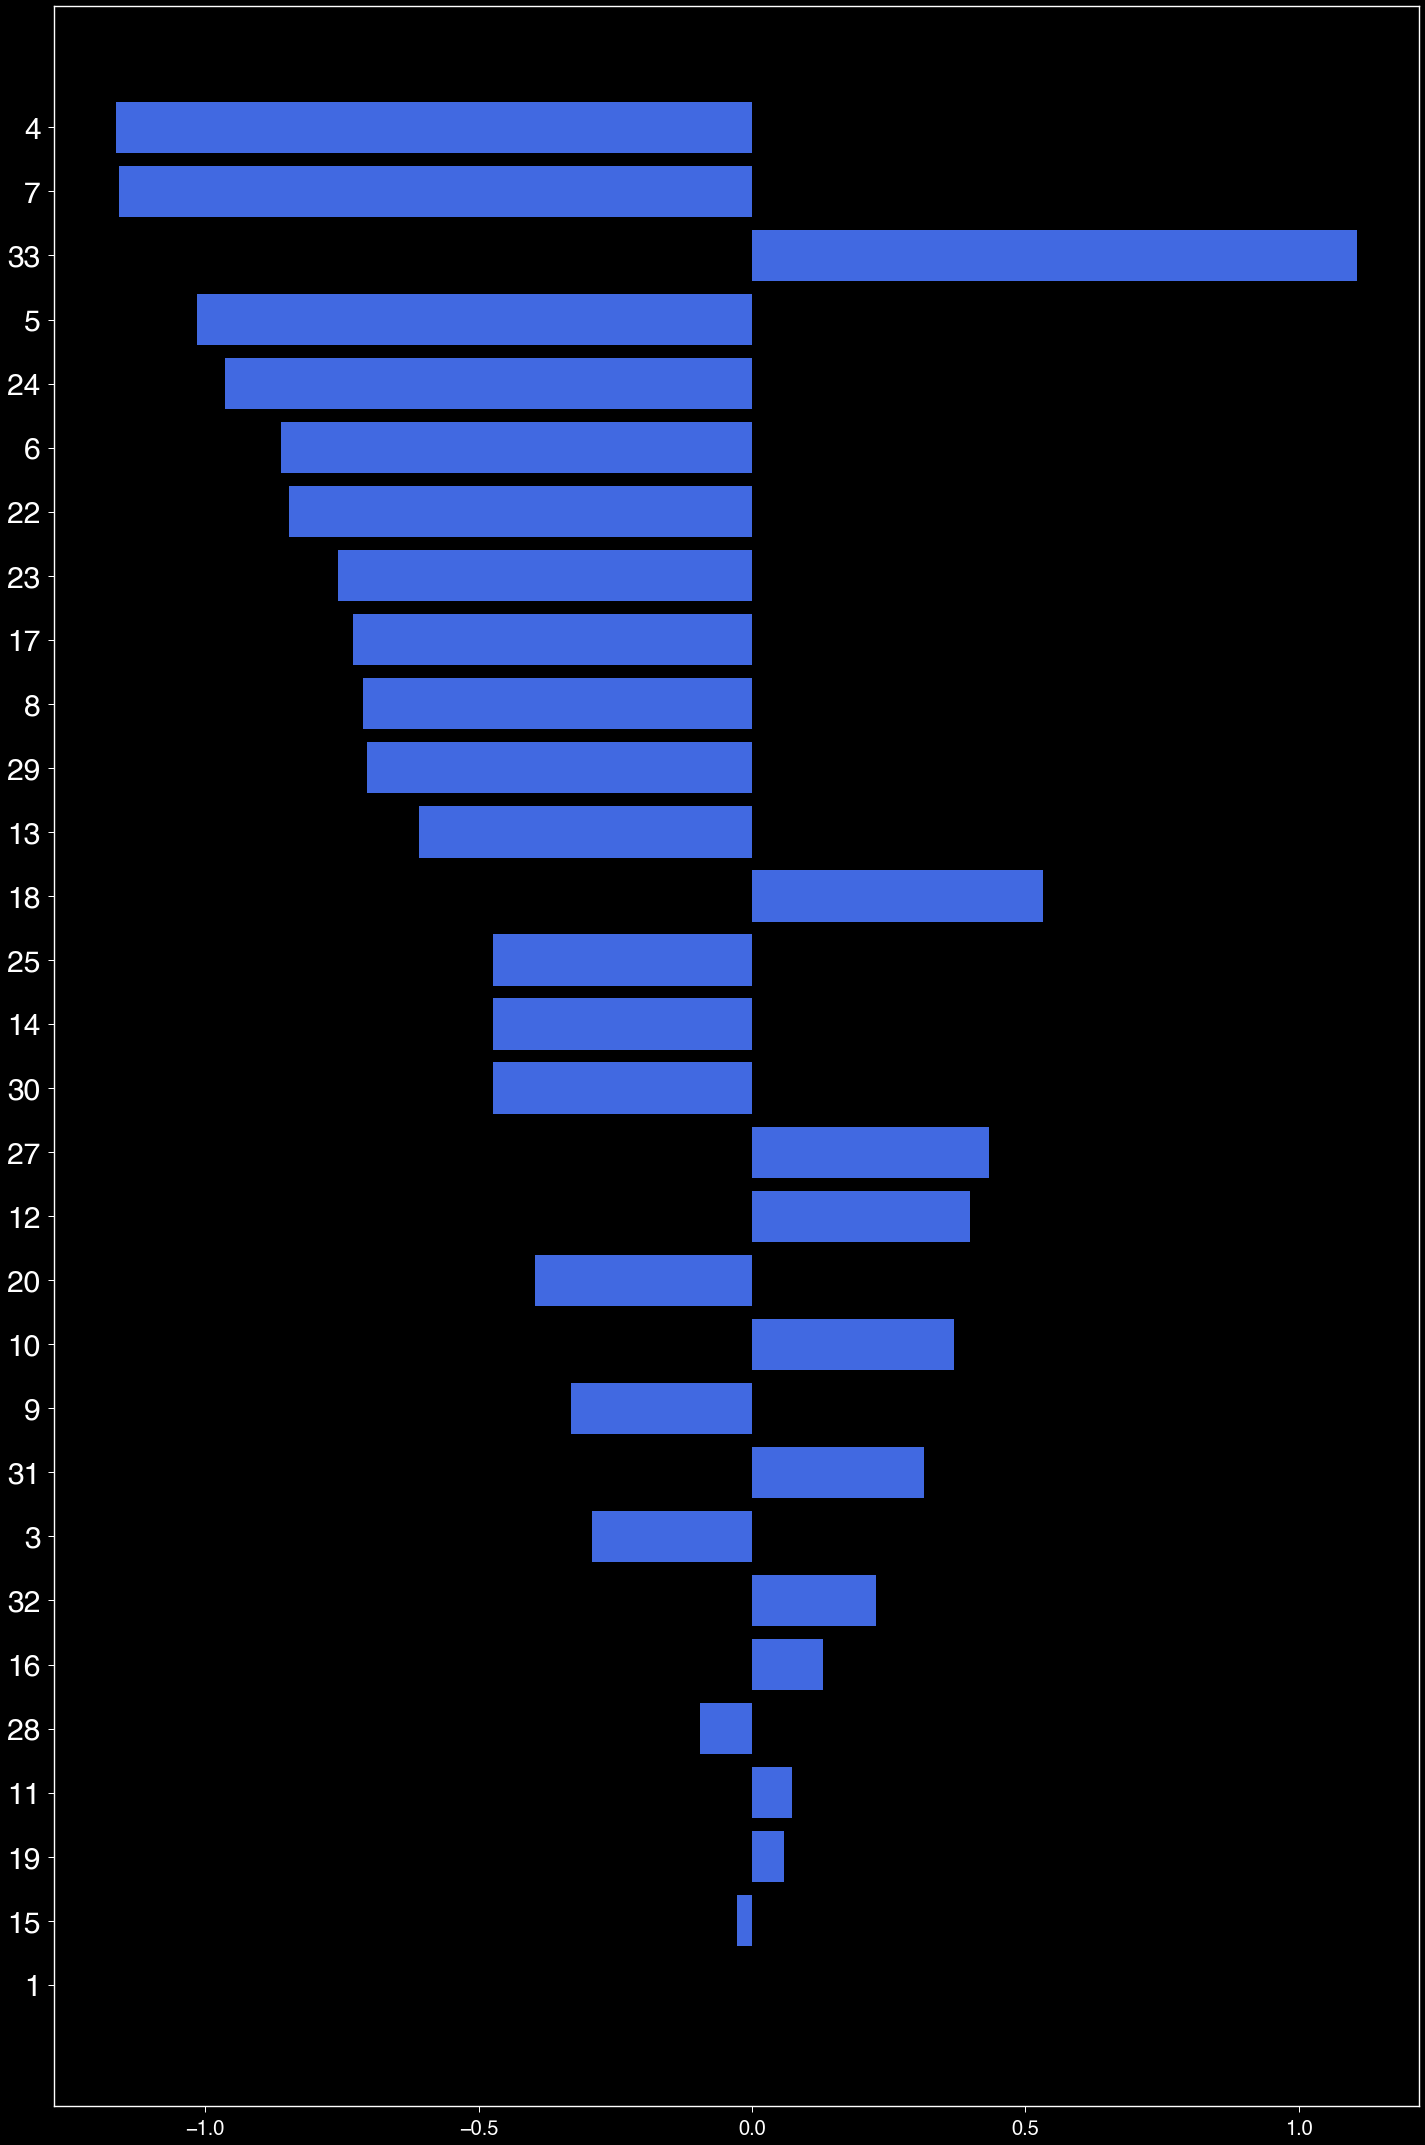

In [30]:
P.coefficients_plot(X_test, cl)

Max depth: None


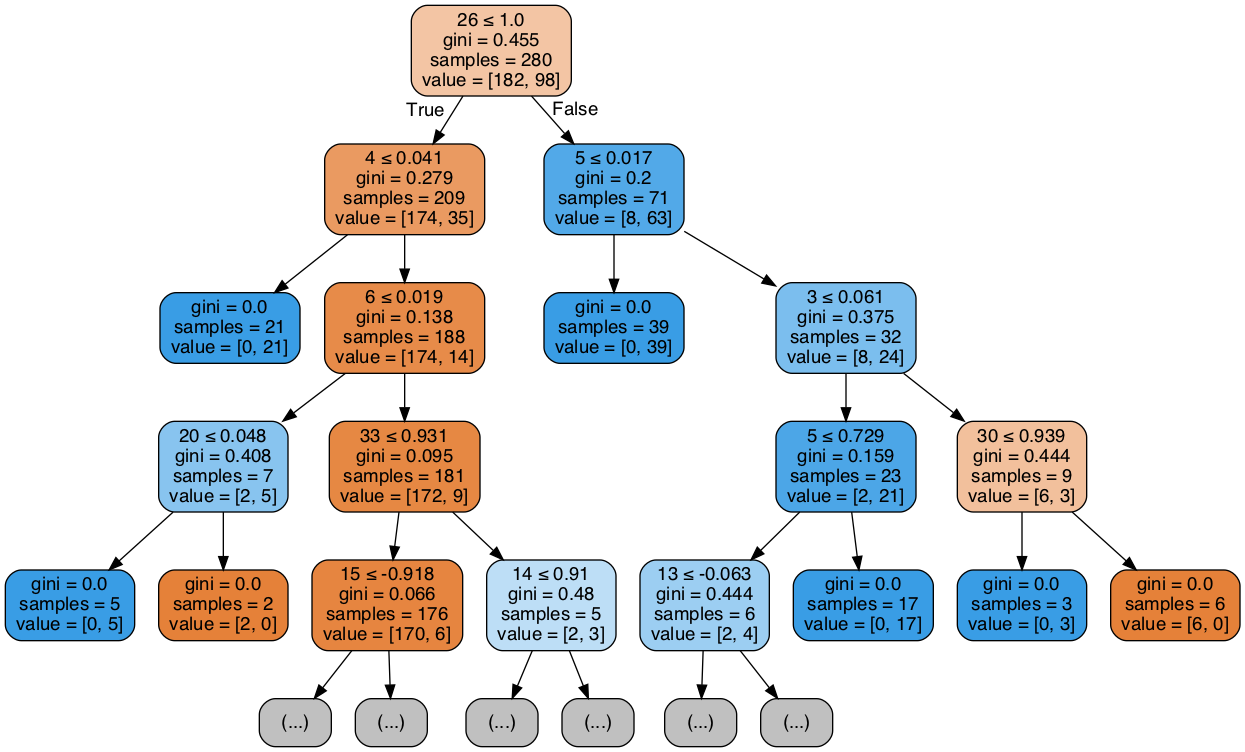

<Figure size 576x504 with 0 Axes>

In [31]:
P.tree_generation(X_test, dt, depth = 4)